In [247]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import scipy
import sklearn
import itertools
import matplotlib.ticker as ticker
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
from sklearn import preprocessing

In [248]:
# read csv
df = pd.read_csv(r"C:\Users\123\Downloads\Collisions.csv")
df.head()

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,-122.392900,47.648646,1,332176,333676,EA40602,Matched,Intersection,26581.0,28TH AVE W AND W DRAVUS ST,...,Dry,Daylight,NaN,NaN,NaN,14,From same direction - both going straight - on...,0,0,N
1,-122.284487,47.603308,2,328504,330004,EA10294,Unmatched,Block,NaN,LAKE WASHINGTON BLVD BETWEEN LAKESIDE AVE AND ...,...,NaN,NaN,NaN,NaN,NaN,,NaN,0,0,Y
2,-122.338480,47.619119,3,329091,330591,EA15604,Matched,Block,NaN,WESTLAKE AVE N BETWEEN DENNY WAY AND JOHN ST,...,Dry,Daylight,NaN,NaN,NaN,11,From same direction - both going straight - bo...,0,0,N
3,-122.358307,47.653110,4,328274,329774,EA07215,Matched,Block,NaN,NW 36TH ST BETWEEN 1ST AVE NW AND LEARY WAY NW,...,Wet,Dark - Street Lights On,NaN,NaN,NaN,32,One parked--one moving,0,0,Y
4,-122.296519,47.733786,5,329003,330503,E986969,Matched,Intersection,35990.0,30TH AVE NE AND NE 145TH ST,...,Dry,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N


In [249]:
# choose features and label
df = df[['OBJECTID','SEVERITYCODE','ADDRTYPE','LOCATION','INCDATE','INCDTTM','JUNCTIONTYPE','WEATHER','ROADCOND','LIGHTCOND','SPEEDING']]
df.head()

,OBJECTID,SEVERITYCODE,ADDRTYPE,LOCATION,INCDATE,INCDTTM,JUNCTIONTYPE,WEATHER,ROADCOND,LIGHTCOND,SPEEDING
0,1,2,Intersection,28TH AVE W AND W DRAVUS ST,2020/06/09 00:00:00+00,6/9/2020 12:48:00 PM,At Intersection (intersection related),Overcast,Dry,Daylight,NaN
1,2,0,Block,LAKE WASHINGTON BLVD BETWEEN LAKESIDE AVE AND ...,2020/02/02 00:00:00+00,2/2/2020,NaN,NaN,NaN,NaN,NaN
2,3,1,Block,WESTLAKE AVE N BETWEEN DENNY WAY AND JOHN ST,2020/02/12 00:00:00+00,2/12/2020 8:00:00 AM,Mid-Block (not related to intersection),Clear,Dry,Daylight,NaN
3,4,1,Block,NW 36TH ST BETWEEN 1ST AVE NW AND LEARY WAY NW,2020/01/23 00:00:00+00,1/23/2020 10:33:00 PM,Mid-Block (not related to intersection),Raining,Wet,Dark - Street Lights On,NaN
4,5,2,Intersection,30TH AVE NE AND NE 145TH ST,2019/11/26 00:00:00+00,11/26/2019 8:26:00 AM,At Intersection (intersection related),Clear,Dry,Daylight,NaN


In [250]:
df.shape

(220937, 11)

In [251]:
df.isnull().any()

OBJECTID        False
SEVERITYCODE     True
ADDRTYPE         True
LOCATION         True
INCDATE         False
INCDTTM         False
JUNCTIONTYPE     True
WEATHER          True
ROADCOND         True
LIGHTCOND        True
SPEEDING         True
dtype: bool

In [252]:
df.isnull().sum()

OBJECTID             0
SEVERITYCODE         1
ADDRTYPE          3711
LOCATION          4583
INCDATE              0
INCDTTM              0
JUNCTIONTYPE     11959
WEATHER          26460
ROADCOND         26380
LIGHTCOND        26548
SPEEDING        211039
dtype: int64

In [253]:
# change type
df['SEVERITYCODE'].replace("2b", 2.5, inplace = True)
df['SEVERITYCODE'] = df['SEVERITYCODE'].astype('float')

# drop unnecessary columns
df.drop(['LOCATION','INCDATE','SPEEDING'],axis=1,inplace=True)

# change datatype
df['INCDTTM'] = pd.to_datetime(df['INCDTTM'])

# insert dayofweek and plus 1
df['dayofweek'] = df['INCDTTM'].dt.dayofweek
df['dayofweek'] = df['dayofweek'] + 1

# drop unnecessary column
df.drop(['INCDTTM'],axis=1,inplace=True)

# drop nan row
df.dropna(subset=["SEVERITYCODE",'ADDRTYPE','JUNCTIONTYPE','WEATHER','ROADCOND','LIGHTCOND'], axis=0, inplace=True)

In [254]:
df.head()

,OBJECTID,SEVERITYCODE,ADDRTYPE,JUNCTIONTYPE,WEATHER,ROADCOND,LIGHTCOND,dayofweek
0,1,2.0,Intersection,At Intersection (intersection related),Overcast,Dry,Daylight,2
2,3,1.0,Block,Mid-Block (not related to intersection),Clear,Dry,Daylight,3
3,4,1.0,Block,Mid-Block (not related to intersection),Raining,Wet,Dark - Street Lights On,4
4,5,2.0,Intersection,At Intersection (intersection related),Clear,Dry,Daylight,2
5,6,1.0,Block,Mid-Block (not related to intersection),Clear,Dry,Daylight,1


In [255]:
df.shape

(187739, 8)

In [256]:
# SEVERITYCODE vs ADDRTYPE
df1 = df[['SEVERITYCODE','ADDRTYPE']]
df1 = pd.DataFrame(df1.groupby(['SEVERITYCODE','ADDRTYPE']).size())
df1.reset_index(level=['SEVERITYCODE','ADDRTYPE'],inplace=True)

pivot1 = df1.pivot(index='ADDRTYPE',columns='SEVERITYCODE')
pivot1.columns = [0.0,1.0,2.0,2.5,3.0]
pivot1

,0.0,1.0,2.0,2.5,3.0
ADDRTYPE,,,,,
Alley,NaN,206.0,29.0,4.0,NaN
Block,NaN,90794.0,29520.0,1481.0,185.0
Intersection,1.0,36240.0,27599.0,1528.0,152.0


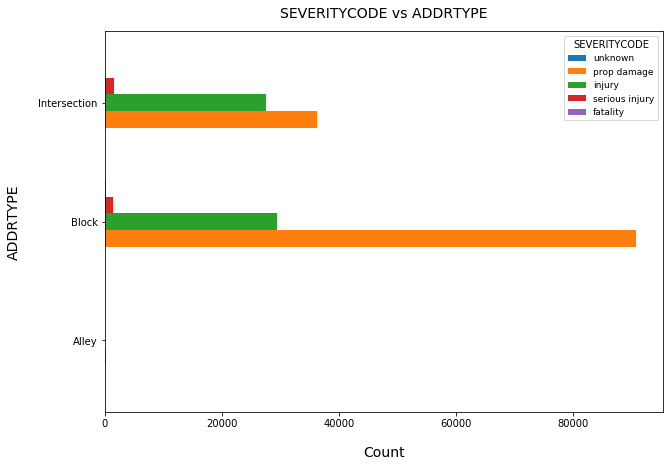

In [257]:
pivot1.plot(kind='barh',width=0.7,figsize=(10,7))
plt.xlabel('Count',fontsize=14,labelpad=17)
plt.ylabel('ADDRTYPE',fontsize=14,labelpad=17)
plt.legend(labels=['unknown','prop damage','injury','serious injury','fatality'],title='SEVERITYCODE',fontsize=9)
plt.title('SEVERITYCODE vs ADDRTYPE',fontsize=14,y=1.02)
plt.savefig('C:/Users/123/Downloads/1.png',bbox_inches = 'tight',dpi=300)
plt.show()

In [258]:
# SEVERITYCODE vs JUNCTIONTYPE
df2 = df[['SEVERITYCODE','JUNCTIONTYPE']]
df2 = pd.DataFrame(df2.groupby(['SEVERITYCODE','JUNCTIONTYPE']).size())
df2.reset_index(level=['SEVERITYCODE','JUNCTIONTYPE'],inplace=True)

pivot2 = df2.pivot(index='JUNCTIONTYPE',columns='SEVERITYCODE')
pivot2.columns = [0.0,1.0,2.0,2.5,3.0]
pivot2

,0.0,1.0,2.0,2.5,3.0
JUNCTIONTYPE,,,,,
At Intersection (but not related to intersection),NaN,1440.0,618.0,23.0,2.0
At Intersection (intersection related),1.0,34773.0,26971.0,1503.0,150.0
Driveway Junction,NaN,7362.0,3210.0,138.0,8.0
Mid-Block (but intersection related),NaN,15205.0,7219.0,187.0,17.0
Mid-Block (not related to intersection),NaN,68346.0,19079.0,1157.0,160.0
Ramp Junction,NaN,110.0,50.0,5.0,NaN
Unknown,NaN,4.0,1.0,NaN,NaN


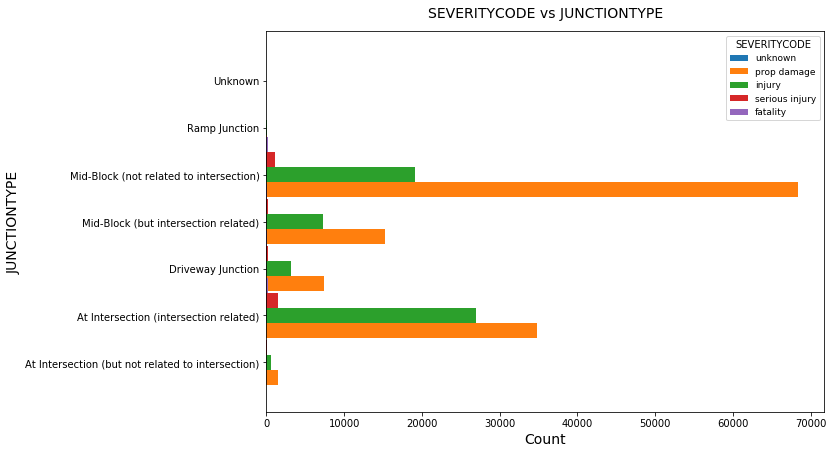

In [259]:
pivot2.plot(kind='barh',width=1.6,figsize=(10,7))
plt.xlabel('Count',fontsize=14)
plt.ylabel('JUNCTIONTYPE',fontsize=14)
plt.legend(labels=['unknown','prop damage','injury','serious injury','fatality'],title='SEVERITYCODE',fontsize=9)
plt.title('SEVERITYCODE vs JUNCTIONTYPE',fontsize=14,y=1.02)
plt.savefig('C:/Users/123/Downloads/2.png',bbox_inches = 'tight',dpi=300)
plt.show()

In [260]:
# SEVERITYCODE vs WEATHER
df3 = df[['SEVERITYCODE','WEATHER']]
df3 = pd.DataFrame(df3.groupby(['SEVERITYCODE','WEATHER']).size())
df3.reset_index(level=['SEVERITYCODE','WEATHER'],inplace=True)

pivot3 = df3.pivot(index='WEATHER',columns='SEVERITYCODE')
pivot3.columns = [0.0,1.0,2.0,2.5,3.0]
pivot3

,0.0,1.0,2.0,2.5,3.0
WEATHER,,,,,
Blowing Sand/Dirt,NaN,36.0,13.0,NaN,NaN
Clear,NaN,74063.0,35906.0,1989.0,226.0
Fog/Smog/Smoke,NaN,370.0,187.0,3.0,3.0
Other,NaN,638.0,117.0,7.0,3.0
Overcast,NaN,18706.0,8761.0,440.0,53.0
Partly Cloudy,NaN,5.0,4.0,NaN,NaN
Raining,1.0,21737.0,11187.0,524.0,50.0
Severe Crosswind,NaN,18.0,7.0,NaN,1.0
Sleet/Hail/Freezing Rain,NaN,85.0,28.0,2.0,NaN


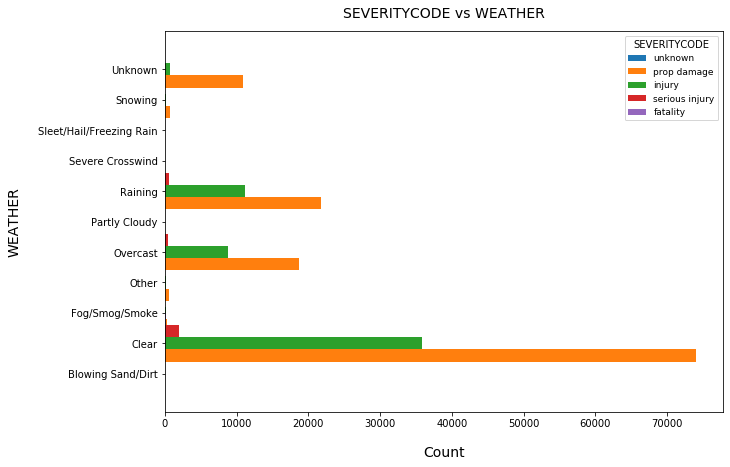

In [261]:
pivot3.plot(kind='barh',width=2,figsize=(10,7))
plt.xlabel('Count',fontsize=14,labelpad=17)
plt.ylabel('WEATHER',fontsize=14,labelpad=17)
plt.legend(labels=['unknown','prop damage','injury','serious injury','fatality'],title='SEVERITYCODE',fontsize=9)
plt.title('SEVERITYCODE vs WEATHER',fontsize=14,y=1.02)
plt.savefig('C:/Users/123/Downloads/3.png',bbox_inches = 'tight',dpi=300)
plt.show()

In [262]:
# SEVERITYCODE vs ROADCOND
df4 = df[['SEVERITYCODE','ROADCOND']]
df4 = pd.DataFrame(df4.groupby(['SEVERITYCODE','ROADCOND']).size())
df4.reset_index(level=['SEVERITYCODE','ROADCOND'],inplace=True)

pivot4 = df4.pivot(index='ROADCOND',columns='SEVERITYCODE')
pivot4.columns = [0.0,1.0,2.0,2.5,3.0]
pivot4

,0.0,1.0,2.0,2.5,3.0
ROADCOND,,,,,
Dry,NaN,83110.0,40108.0,2202.0,266.0
Ice,NaN,911.0,270.0,18.0,1.0
Oil,NaN,36.0,24.0,NaN,NaN
Other,NaN,82.0,42.0,3.0,NaN
Sand/Mud/Dirt,NaN,47.0,22.0,NaN,NaN
Snow/Slush,NaN,815.0,165.0,8.0,NaN
Standing Water,NaN,80.0,29.0,2.0,NaN
Unknown,NaN,10827.0,713.0,29.0,1.0
Wet,1.0,31332.0,15775.0,751.0,69.0


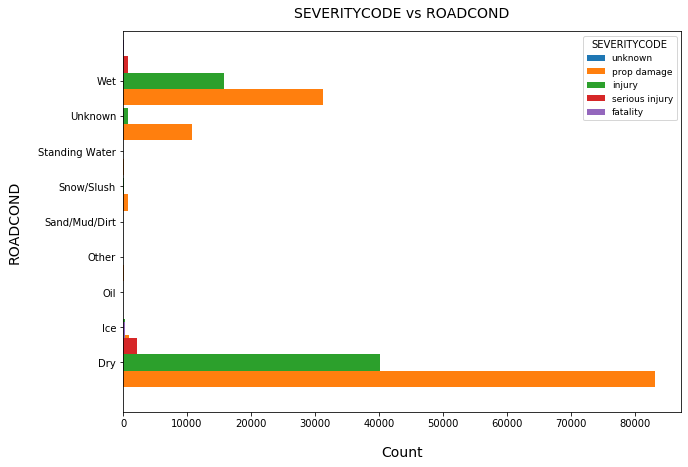

In [263]:
pivot4.plot(kind='barh',width=2.3,figsize=(10,7))
plt.xlabel('Count',fontsize=14,labelpad=17)
plt.ylabel('ROADCOND',fontsize=14,labelpad=17)
plt.legend(labels=['unknown','prop damage','injury','serious injury','fatality'],title='SEVERITYCODE',fontsize=9)
plt.title('SEVERITYCODE vs ROADCOND',fontsize=14,y=1.02)
plt.savefig('C:/Users/123/Downloads/4.png',bbox_inches = 'tight',dpi=300)
plt.show()

In [264]:
# SEVERITYCODE vs LIGHTCOND
df5 = df[['SEVERITYCODE','LIGHTCOND']]
df5 = pd.DataFrame(df5.groupby(['SEVERITYCODE','LIGHTCOND']).size())
df5.reset_index(level=['SEVERITYCODE','LIGHTCOND'],inplace=True)

pivot5 = df5.pivot(index='LIGHTCOND',columns='SEVERITYCODE')
pivot5.columns = [0.0,1.0,2.0,2.5,3.0]
pivot5

,0.0,1.0,2.0,2.5,3.0
LIGHTCOND,,,,,
Dark - No Street Lights,NaN,1141.0,332.0,24.0,1.0
Dark - Street Lights Off,NaN,849.0,313.0,28.0,4.0
Dark - Street Lights On,NaN,33436.0,14481.0,1003.0,144.0
Dark - Unknown Lighting,NaN,12.0,8.0,NaN,NaN
Dawn,NaN,1653.0,831.0,59.0,5.0
Daylight,1.0,76225.0,38609.0,1761.0,168.0
Dusk,NaN,3877.0,1941.0,110.0,14.0
Other,NaN,160.0,54.0,4.0,NaN
Unknown,NaN,9887.0,579.0,24.0,1.0


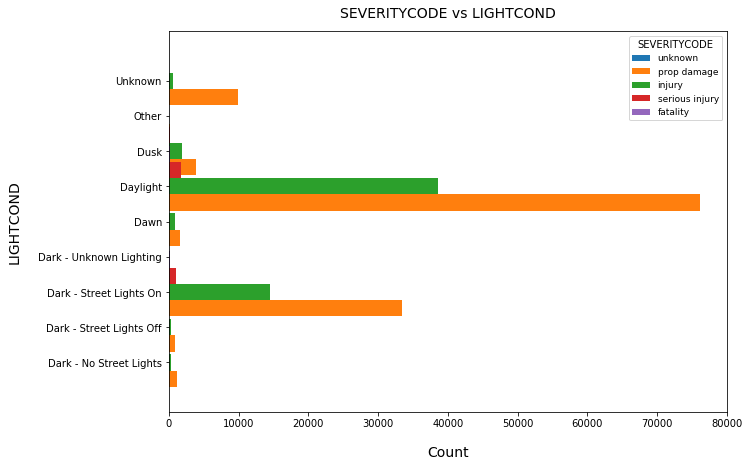

In [265]:
pivot5.plot(kind='barh',width=2.3,figsize=(10,7))
plt.xlabel('Count',fontsize=14,labelpad=17)
plt.ylabel('LIGHTCOND',fontsize=14,labelpad=17)
plt.legend(labels=['unknown','prop damage','injury','serious injury','fatality'],title='SEVERITYCODE',fontsize=9)
plt.title('SEVERITYCODE vs LIGHTCOND',fontsize=14,y=1.02)
plt.savefig('C:/Users/123/Downloads/5.png',bbox_inches = 'tight',dpi=300)
plt.show()

In [266]:
# SEVERITYCODE vs dayofweek
df6 = df[['SEVERITYCODE','dayofweek']]
df6 = pd.DataFrame(df6.groupby(['SEVERITYCODE','dayofweek']).size())
df6.reset_index(level=['SEVERITYCODE','dayofweek'],inplace=True)

pivot6 = df6.pivot(index='dayofweek',columns='SEVERITYCODE')
pivot6.columns = [0.0,1.0,2.0,2.5,3.0]
pivot6

,0.0,1.0,2.0,2.5,3.0
dayofweek,,,,,
1,NaN,16971.0,7835.0,392.0,44.0
2,NaN,18405.0,8552.0,442.0,34.0
3,NaN,18606.0,8573.0,428.0,58.0
4,1.0,18879.0,8888.0,488.0,46.0
5,NaN,21218.0,9382.0,499.0,62.0
6,NaN,18250.0,7913.0,406.0,47.0
7,NaN,14911.0,6005.0,358.0,46.0


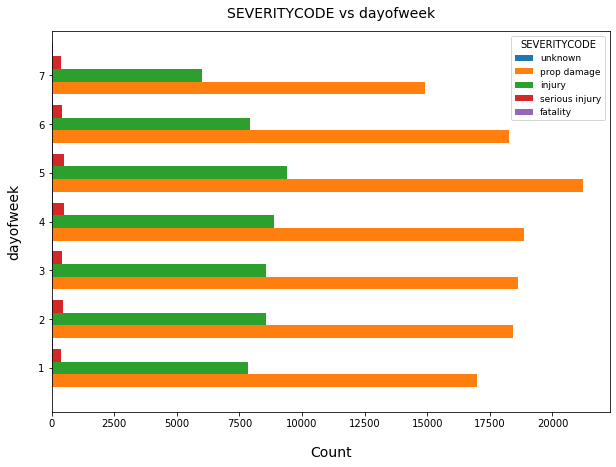

In [267]:
pivot6.plot(kind='barh',width=1.3,figsize=(10,7))
plt.xlabel('Count',fontsize=14,labelpad=17)
plt.ylabel('dayofweek',fontsize=14,labelpad=17)
plt.legend(labels=['unknown','prop damage','injury','serious injury','fatality'],title='SEVERITYCODE',fontsize=9)
plt.title('SEVERITYCODE vs dayofweek',fontsize=14,y=1.02)
plt.savefig('C:/Users/123/Downloads/6.png',bbox_inches = 'tight',dpi=300)
plt.show()

In [268]:
df.head()

,OBJECTID,SEVERITYCODE,ADDRTYPE,JUNCTIONTYPE,WEATHER,ROADCOND,LIGHTCOND,dayofweek
0,1,2.0,Intersection,At Intersection (intersection related),Overcast,Dry,Daylight,2
2,3,1.0,Block,Mid-Block (not related to intersection),Clear,Dry,Daylight,3
3,4,1.0,Block,Mid-Block (not related to intersection),Raining,Wet,Dark - Street Lights On,4
4,5,2.0,Intersection,At Intersection (intersection related),Clear,Dry,Daylight,2
5,6,1.0,Block,Mid-Block (not related to intersection),Clear,Dry,Daylight,1


In [269]:
df.reset_index(inplace=True)

In [270]:
df.head()

,index,OBJECTID,SEVERITYCODE,ADDRTYPE,JUNCTIONTYPE,WEATHER,ROADCOND,LIGHTCOND,dayofweek
0,0,1,2.0,Intersection,At Intersection (intersection related),Overcast,Dry,Daylight,2
1,2,3,1.0,Block,Mid-Block (not related to intersection),Clear,Dry,Daylight,3
2,3,4,1.0,Block,Mid-Block (not related to intersection),Raining,Wet,Dark - Street Lights On,4
3,4,5,2.0,Intersection,At Intersection (intersection related),Clear,Dry,Daylight,2
4,5,6,1.0,Block,Mid-Block (not related to intersection),Clear,Dry,Daylight,1


In [271]:
df.drop(['OBJECTID','index'],axis=1,inplace=True)

In [272]:
df.reset_index(inplace=True)

In [273]:
df['index'] = df['index'] + 1

In [274]:
df.set_index(['index'],inplace=True)

In [275]:
df

,SEVERITYCODE,ADDRTYPE,JUNCTIONTYPE,WEATHER,ROADCOND,LIGHTCOND,dayofweek
index,,,,,,,
1,2.0,Intersection,At Intersection (intersection related),Overcast,Dry,Daylight,2
2,1.0,Block,Mid-Block (not related to intersection),Clear,Dry,Daylight,3
3,1.0,Block,Mid-Block (not related to intersection),Raining,Wet,Dark - Street Lights On,4
4,2.0,Intersection,At Intersection (intersection related),Clear,Dry,Daylight,2
5,1.0,Block,Mid-Block (not related to intersection),Clear,Dry,Daylight,1
...,...,...,...,...,...,...,...
187735,2.0,Intersection,At Intersection (intersection related),Raining,Wet,Daylight,1
187736,1.0,Block,Driveway Junction,Clear,Dry,Daylight,3
187737,2.5,Block,Mid-Block (not related to intersection),Clear,Dry,Dark - Street Lights On,1


In [276]:
list1 = list(df.columns.values)[1:7]
for i in list1:
    print(i,'\n',df[i].value_counts(),'\n')

ADDRTYPE 
 Block           121980
Intersection     65520
Alley              239
Name: ADDRTYPE, dtype: int64 

JUNCTIONTYPE 
 Mid-Block (not related to intersection)              88742
At Intersection (intersection related)               63398
Mid-Block (but intersection related)                 22628
Driveway Junction                                    10718
At Intersection (but not related to intersection)     2083
Ramp Junction                                          165
Unknown                                                  5
Name: JUNCTIONTYPE, dtype: int64 

WEATHER 
 Clear                       112184
Raining                      33499
Overcast                     27960
Unknown                      11676
Snowing                        893
Other                          765
Fog/Smog/Smoke                 563
Sleet/Hail/Freezing Rain       115
Blowing Sand/Dirt               49
Severe Crosswind                26
Partly Cloudy                    9
Name: WEATHER, dtype: int64 

R

In [277]:
df['ADDRTYPE'] = df['ADDRTYPE'].replace('Block',1)
df['ADDRTYPE'] = df['ADDRTYPE'].replace('Intersection',2)
df['ADDRTYPE'] = df['ADDRTYPE'].replace('Alley',3)

In [278]:
df['JUNCTIONTYPE'] = df['JUNCTIONTYPE'].replace('Mid-Block (not related to intersection)',1)
df['JUNCTIONTYPE'] = df['JUNCTIONTYPE'].replace('At Intersection (intersection related)',2)
df['JUNCTIONTYPE'] = df['JUNCTIONTYPE'].replace('Mid-Block (but intersection related)',3)
df['JUNCTIONTYPE'] = df['JUNCTIONTYPE'].replace('Driveway Junction',4)
df['JUNCTIONTYPE'] = df['JUNCTIONTYPE'].replace('At Intersection (but not related to intersection)',5)
df['JUNCTIONTYPE'] = df['JUNCTIONTYPE'].replace('Ramp Junction',6)
df['JUNCTIONTYPE'] = df['JUNCTIONTYPE'].replace('Unknown',7)

In [279]:
df['WEATHER'] = df['WEATHER'].replace('Clear',1)
df['WEATHER'] = df['WEATHER'].replace('Raining',2)
df['WEATHER'] = df['WEATHER'].replace('Overcast',3)
df['WEATHER'] = df['WEATHER'].replace('Unknown',4)
df['WEATHER'] = df['WEATHER'].replace('Snowing',5)
df['WEATHER'] = df['WEATHER'].replace('Other',6)
df['WEATHER'] = df['WEATHER'].replace('Fog/Smog/Smoke',7)
df['WEATHER'] = df['WEATHER'].replace('Sleet/Hail/Freezing Rain',8)
df['WEATHER'] = df['WEATHER'].replace('Blowing Sand/Dirt',9)
df['WEATHER'] = df['WEATHER'].replace('Severe Crosswind',10)
df['WEATHER'] = df['WEATHER'].replace('Partly Cloudy',11)

In [280]:
df['ROADCOND'] = df['ROADCOND'].replace('Dry',1)
df['ROADCOND'] = df['ROADCOND'].replace('Wet',2)
df['ROADCOND'] = df['ROADCOND'].replace('Unknown',3)
df['ROADCOND'] = df['ROADCOND'].replace('Ice',4)
df['ROADCOND'] = df['ROADCOND'].replace('Snow/Slush',5)
df['ROADCOND'] = df['ROADCOND'].replace('Other',6)
df['ROADCOND'] = df['ROADCOND'].replace('Standing Water',7)
df['ROADCOND'] = df['ROADCOND'].replace('Sand/Mud/Dirt',8)
df['ROADCOND'] = df['ROADCOND'].replace('Oil',9)

In [281]:
df['LIGHTCOND'] = df['LIGHTCOND'].replace('Daylight',1)
df['LIGHTCOND'] = df['LIGHTCOND'].replace('Dark - Street Lights On',2)
df['LIGHTCOND'] = df['LIGHTCOND'].replace('Unknown',3)
df['LIGHTCOND'] = df['LIGHTCOND'].replace('Dusk',4)
df['LIGHTCOND'] = df['LIGHTCOND'].replace('Dawn',5)
df['LIGHTCOND'] = df['LIGHTCOND'].replace('Dark - No Street Lights',6)
df['LIGHTCOND'] = df['LIGHTCOND'].replace('Dark - Street Lights Off',7)
df['LIGHTCOND'] = df['LIGHTCOND'].replace('Other',8)
df['LIGHTCOND'] = df['LIGHTCOND'].replace('Dark - Unknown Lighting',9)

In [282]:
df

,SEVERITYCODE,ADDRTYPE,JUNCTIONTYPE,WEATHER,ROADCOND,LIGHTCOND,dayofweek
index,,,,,,,
1,2.0,2,2,3,1,1,2
2,1.0,1,1,1,1,1,3
3,1.0,1,1,2,2,2,4
4,2.0,2,2,1,1,1,2
5,1.0,1,1,1,1,1,1
...,...,...,...,...,...,...,...
187735,2.0,2,2,2,2,1,1
187736,1.0,1,4,1,1,1,3
187737,2.5,1,1,1,1,2,1


In [283]:
X = df[['ADDRTYPE','JUNCTIONTYPE','WEATHER','ROADCOND','LIGHTCOND','dayofweek']]
y = df[['SEVERITYCODE']].values.ravel()

In [284]:
X = X * 30
y = y * 30

In [285]:
X = preprocessing.StandardScaler().fit(X).transform(X)

In [286]:
X

array([[ 1.35064486,  0.21242317,  1.18475574, -0.58925572, -0.57900133,
        -1.01311048],
       [-0.73220903, -0.84417163, -0.67860622, -0.58925572, -0.57900133,
        -0.49283183],
       [-0.73220903, -0.84417163,  0.25307476,  0.77845952,  0.37115015,
         0.02744683],
       ...,
       [-0.73220903, -0.84417163, -0.67860622, -0.58925572,  0.37115015,
        -1.53338913],
       [-0.73220903,  2.32561278,  3.97979868,  2.14617477,  0.37115015,
        -1.01311048],
       [-0.73220903, -0.84417163,  3.97979868,  2.14617477, -0.57900133,
         0.02744683]])

# KNN

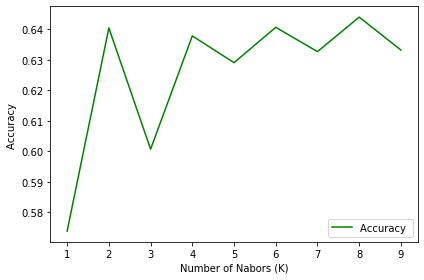

The best accuracy was with 0.6440023436667732 with k= 8


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
X1_train,X1_test,y1_train,y1_test = train_test_split(X,y,test_size=0.2,random_state=4)
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X1_train,y1_train)
    yhat1=neigh.predict(X1_test)
    mean_acc[n-1] = metrics.accuracy_score(y1_test, yhat1)

    
    std_acc[n-1]=np.std(yhat1==y1_test)/np.sqrt(yhat1.shape[0])

mean_acc
plt.plot(range(1,Ks),mean_acc,'g')

plt.legend(('Accuracy ', '+/- 3xstd'),fontsize=9)
plt.ylabel('Accuracy ',fontsize=14,labelpad=17)
plt.xlabel('Number of Nabors (K)',fontsize=14,labelpad=17)
plt.tight_layout()
plt.savefig('C:/Users/123/Downloads/7.png',bbox_inches = 'tight',dpi=300)
plt.show()
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

In [42]:
Collisionsneigh = KNeighborsClassifier(8).fit(X1_train,y1_train)
yhat1 = Collisionsneigh.predict(X1_test)

In [44]:
from sklearn.metrics import jaccard_similarity_score
j1 = jaccard_similarity_score(y1_test, yhat1)
j1

0.6440023436667732

In [45]:
from sklearn.metrics import f1_score
f1 = f1_score(y1_test, yhat1, average='weighted')
f1

0.587870335832594

# Decision Tree

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
X2_train,X2_test,y2_train,y2_test = train_test_split(X,y,test_size=0.2,random_state=4)
CollisionsTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
CollisionsTree.fit(X2_train,y2_train)
yhat2 = CollisionsTree.predict(X2_test)

In [49]:
from sklearn.metrics import jaccard_similarity_score
j2 = jaccard_similarity_score(y2_test, yhat2)
j2

0.6765207201448812

In [50]:
from sklearn.metrics import f1_score
f2 = f1_score(y2_test, yhat2, average='weighted')
f2

0.5459882234510015

# Support Vector Machine

In [51]:
from sklearn.model_selection import train_test_split
from sklearn import svm
X3_train,X3_test,y3_train,y3_test = train_test_split(X,y,test_size=0.2,random_state=4)
CollisionsSVM = svm.SVC(kernel='rbf')
CollisionsSVM.fit(X3_train, y3_train) 
yhat3 = CollisionsSVM.predict(X3_test)

In [61]:
from sklearn.metrics import jaccard_similarity_score
j3 = jaccard_similarity_score(y3_test, yhat3)
j3

0.6765207201448812

In [62]:
from sklearn.metrics import f1_score
f3 = f1_score(y3_test, yhat3, average='weighted')
f3

0.5462335783770929

# Logistic Regression

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
X4_train,X4_test,y4_train,y4_test = train_test_split(X,y,test_size=0.2,random_state=4)
CollisionsLR = LogisticRegression(C=0.01, solver='liblinear')
CollisionsLR.fit(X4_train,y4_train)
yhat4 = CollisionsLR.predict(X4_test)

In [67]:
from sklearn.metrics import jaccard_similarity_score
j4 = jaccard_similarity_score(y4_test, yhat4)
j4

0.6732449131777991

In [69]:
from sklearn.metrics import f1_score
f4 = f1_score(y4_test, yhat4, average='weighted')
f4

0.5484759130295178